In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches

In [3]:
import plotnine as p9

In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200)

/gstore/home/wub31/.conda/envs/scanpy_Mar2022_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [5]:
aliquot_numbers=['1','2','3','4','5','6','7','8','9','10','11','12']

In [ ]:
adata = [sc.read_10x_mtx(directoryname,  
    var_names='gene_symbols',                  
    cache=True,gex_only=False)                                # write a cache file for faster subsequent reading
 for directoryname in ['/gne/data/dnaseq/analysis/labstaff/wub31/Traceseq_Jan2023/T3_OAK/GEXandLineage_T3aliquot'+ d + '_force/outs/filtered_feature_bc_matrix' for d in aliquot_numbers ]]


In [8]:
for i in range(0,len(adata)):     
    adata[i].obs['aliquot']=aliquot_numbers[i]
    adata[i].obs['cell_bc']=adata[i].obs.index

In [9]:
adata = adata[0].concatenate(adata[1:]) 
len(adata.obs)

72000

In [10]:
adata.obs

,aliquot,cell_bc,batch
AAACCCACAAATGATG-1-0,1,AAACCCACAAATGATG-1,0
AAACCCACAGACCCGT-1-0,1,AAACCCACAGACCCGT-1,0
AAACCCATCCCATAAG-1-0,1,AAACCCATCCCATAAG-1,0
AAACCCATCGATCCAA-1-0,1,AAACCCATCGATCCAA-1,0
AAACGAACAACGAGGT-1-0,1,AAACGAACAACGAGGT-1,0
...,...,...,...
TTTGGTTTCTTTCTAG-1-11,12,TTTGGTTTCTTTCTAG-1,11
TTTGTTGGTCACCACG-1-11,12,TTTGTTGGTCACCACG-1,11
TTTGTTGGTCTACACA-1-11,12,TTTGTTGGTCTACACA-1,11
TTTGTTGTCGGCATAT-1-11,12,TTTGTTGTCGGCATAT-1,11


In [13]:
adata.write(output_d+'/T3_OAK/Anndata/OAK1to12_GEXwLineage_raw.h5ad')

In [14]:
LineageName=adata.var.index[adata.var['feature_types']== "CRISPR Guide Capture"]

In [15]:
LineageData=sc.get.obs_df(adata,keys=LineageName.tolist())

In [16]:
TopSup=LineageData.apply(lambda row: row.nlargest(2).values[0],axis=1)

In [17]:
df_lineage=TopSup.to_frame()

In [18]:
df_lineage.columns=['nUMI_TopSupLineage']

In [19]:
df_lineage['nUMI_secondary']=LineageData.apply(lambda row: row.nlargest(2).values[-1],axis=1)

In [20]:
df_lineage['second/top']=df_lineage['nUMI_secondary']/df_lineage['nUMI_TopSupLineage']

In [21]:
df_lineage['Lineage_assigned']=LineageData.idxmax(axis=1)*(df_lineage['second/top']<=0.5)

In [22]:
df_lineage

,nUMI_TopSupLineage,nUMI_secondary,second/top,Lineage_assigned
AAACCCACAAATGATG-1-0,1.0,0.0,0.000000,GENBC0266316
AAACCCACAGACCCGT-1-0,1.0,0.0,0.000000,GENBC0218015
AAACCCATCCCATAAG-1-0,0.0,0.0,NaN,
AAACCCATCGATCCAA-1-0,1.0,0.0,0.000000,GENBC0294437
AAACGAACAACGAGGT-1-0,1.0,1.0,1.000000,
...,...,...,...,...
TTTGGTTTCTTTCTAG-1-11,1.0,1.0,1.000000,
TTTGTTGGTCACCACG-1-11,2.0,1.0,0.500000,GENBC0218015
TTTGTTGGTCTACACA-1-11,3.0,1.0,0.333333,GENBC0218015
TTTGTTGTCGGCATAT-1-11,4.0,1.0,0.250000,GENBC0218015


In [25]:
adata.obs=adata.obs.merge(df_lineage,how="left",left_index=True,right_index=True)

In [33]:
GEX_adata_filtered=adata[adata.obs['Lineage_assigned']!='',adata.var["feature_types"] == "Gene Expression"]

In [34]:
GEX_adata_filtered

View of AnnData object with n_obs × n_vars = 40554 × 36601
    obs: 'aliquot', 'cell_bc', 'batch', 'nUMI_TopSupLineage', 'nUMI_secondary', 'second/top', 'Lineage_assigned'
    var: 'gene_ids', 'feature_types'

In [35]:
GEX_adata_filtered.write(output_d+'/T3_OAK/Anndata/OAK1to12_GEXwLineage_filtered.h5ad')

/gstore/home/wub31/.conda/envs/scanpy_Mar2022_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
/gstore/home/wub31/.conda/envs/scanpy_Mar2022_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Lineage_assigned' as categorical


In [6]:
df_T3oak1to12_LineageSum=GEX_adata_filtered.obs.Lineage_assigned.value_counts().to_frame()

In [7]:
df_T3oak1to12_LineageSum.Lineage_assigned.sum()

40554

In [8]:
df_T3oak1to12_LineageSum['pct_cells']=df_T3oak1to12_LineageSum.Lineage_assigned/40554

In [9]:
df_T3oak1to12_LineageSum['Lineage_id']=df_T3oak1to12_LineageSum.index

In [10]:
df_T3oak1to12_LineageSum.columns=['T3oak1to12_NumCells','T3oak1to12_PctCells','LineageID']

In [11]:
df_T3oak1to12_LineageSum

,T3oak1to12_NumCells,T3oak1to12_PctCells,LineageID
GENBC0218015,31040,0.765399,GENBC0218015
GENBC0253909,1232,0.030379,GENBC0253909
GENBC0266182,830,0.020467,GENBC0266182
GENBC0256755,696,0.017162,GENBC0256755
GENBC0226882,409,0.010085,GENBC0226882
...,...,...,...
GENBC0293112,1,0.000025,GENBC0293112
GENBC0228831,1,0.000025,GENBC0228831
GENBC0245847,1,0.000025,GENBC0245847
GENBC0288158,1,0.000025,GENBC0288158


In [12]:
df_T3oak1to12_LineageSum.to_csv(output_d+'/T3_OAK/Anndata/OAK1to12_lineage_summary.csv',index=False)

In [14]:
sc.pp.calculate_qc_metrics(GEX_adata_filtered, inplace=True)


In [15]:
ribo_genes = GEX_adata_filtered.var_names.str.startswith(('RPS','RPL'))
sum(ribo_genes)

103

In [16]:
GEX_adata_filtered.obs['percent_ribo'] = np.sum(
    GEX_adata_filtered[:, ribo_genes].X, axis=1).A1 / np.sum(GEX_adata_filtered.X, axis=1).A1

In [17]:
mito_genes = GEX_adata_filtered.var_names.str.startswith(('MT-'))
sum(mito_genes)

13

In [18]:
GEX_adata_filtered.obs['percent_mito'] = np.sum(
    GEX_adata_filtered[:, mito_genes].X, axis=1).A1 / np.sum(GEX_adata_filtered.X, axis=1).A1

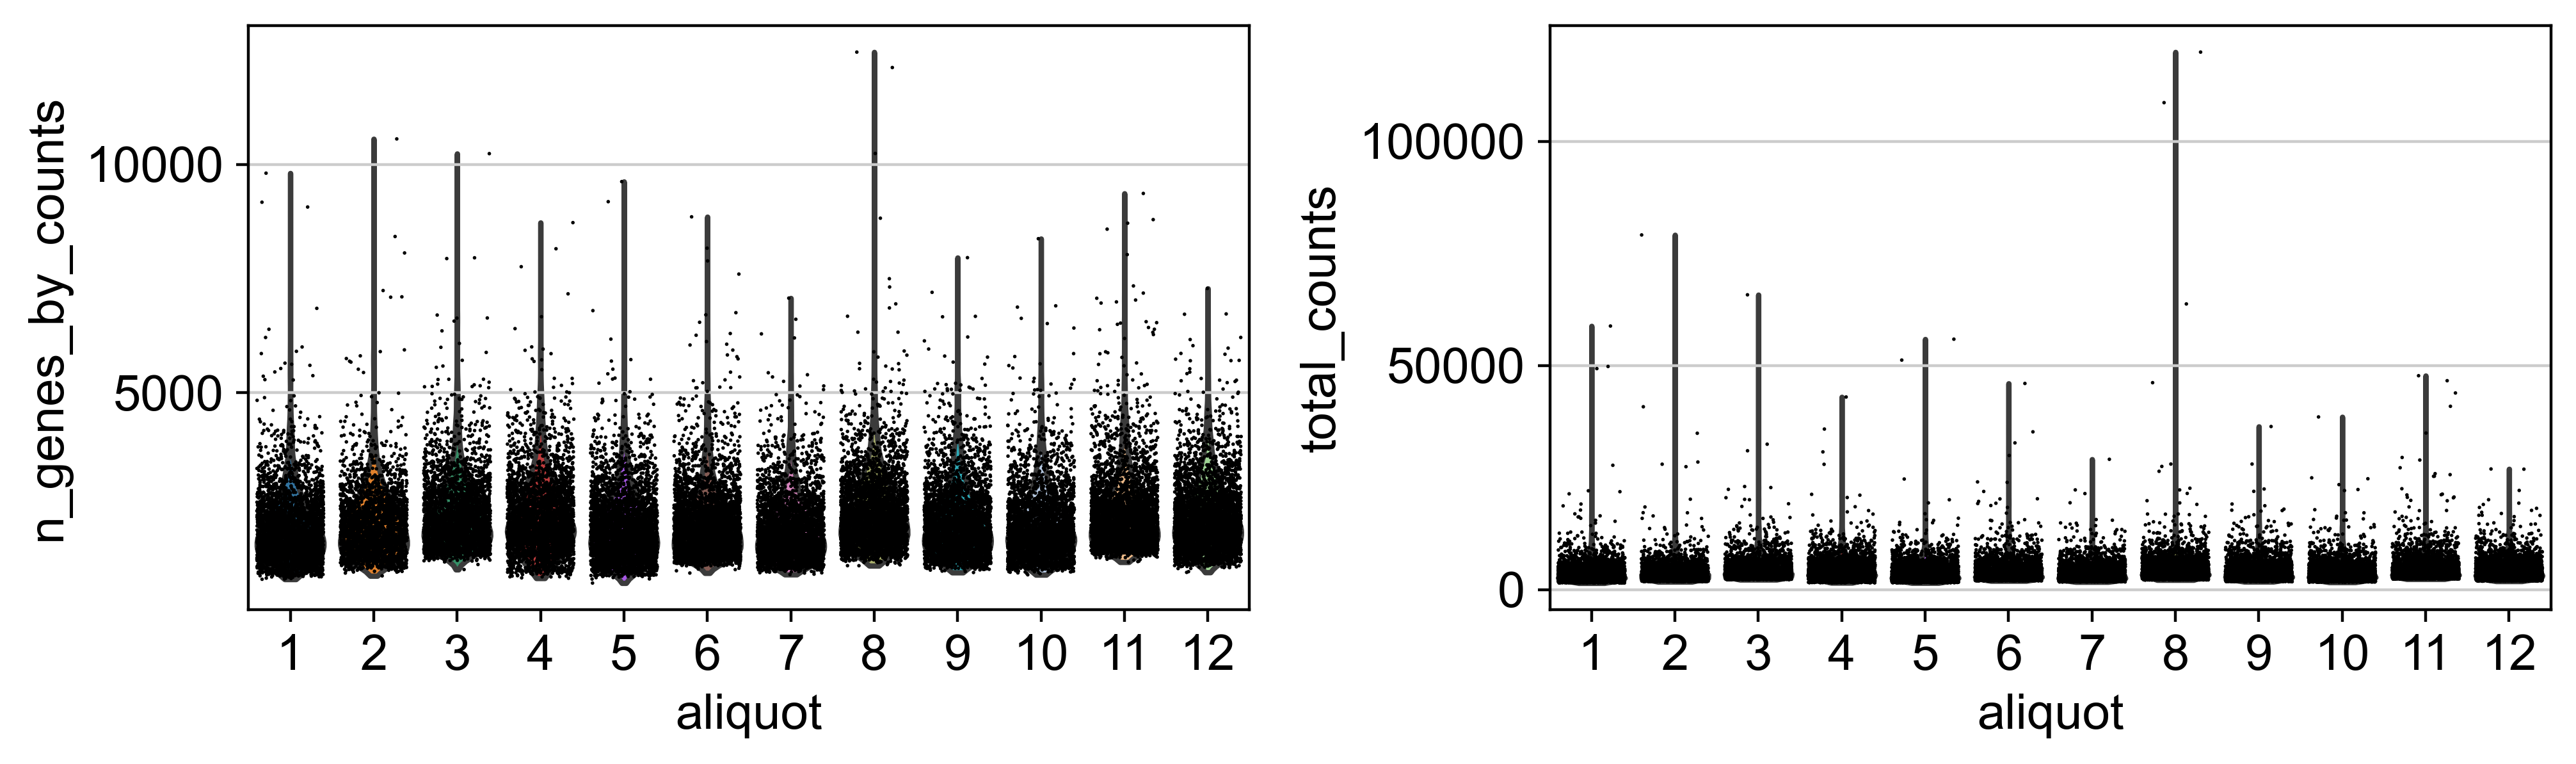

In [19]:
with plt.rc_context({'figure.figsize': (5, 3)}):
    sc.pl.violin(GEX_adata_filtered, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True,groupby='aliquot')

In [20]:
np.mean(GEX_adata_filtered.obs.n_genes_by_counts)

2193.768234945998

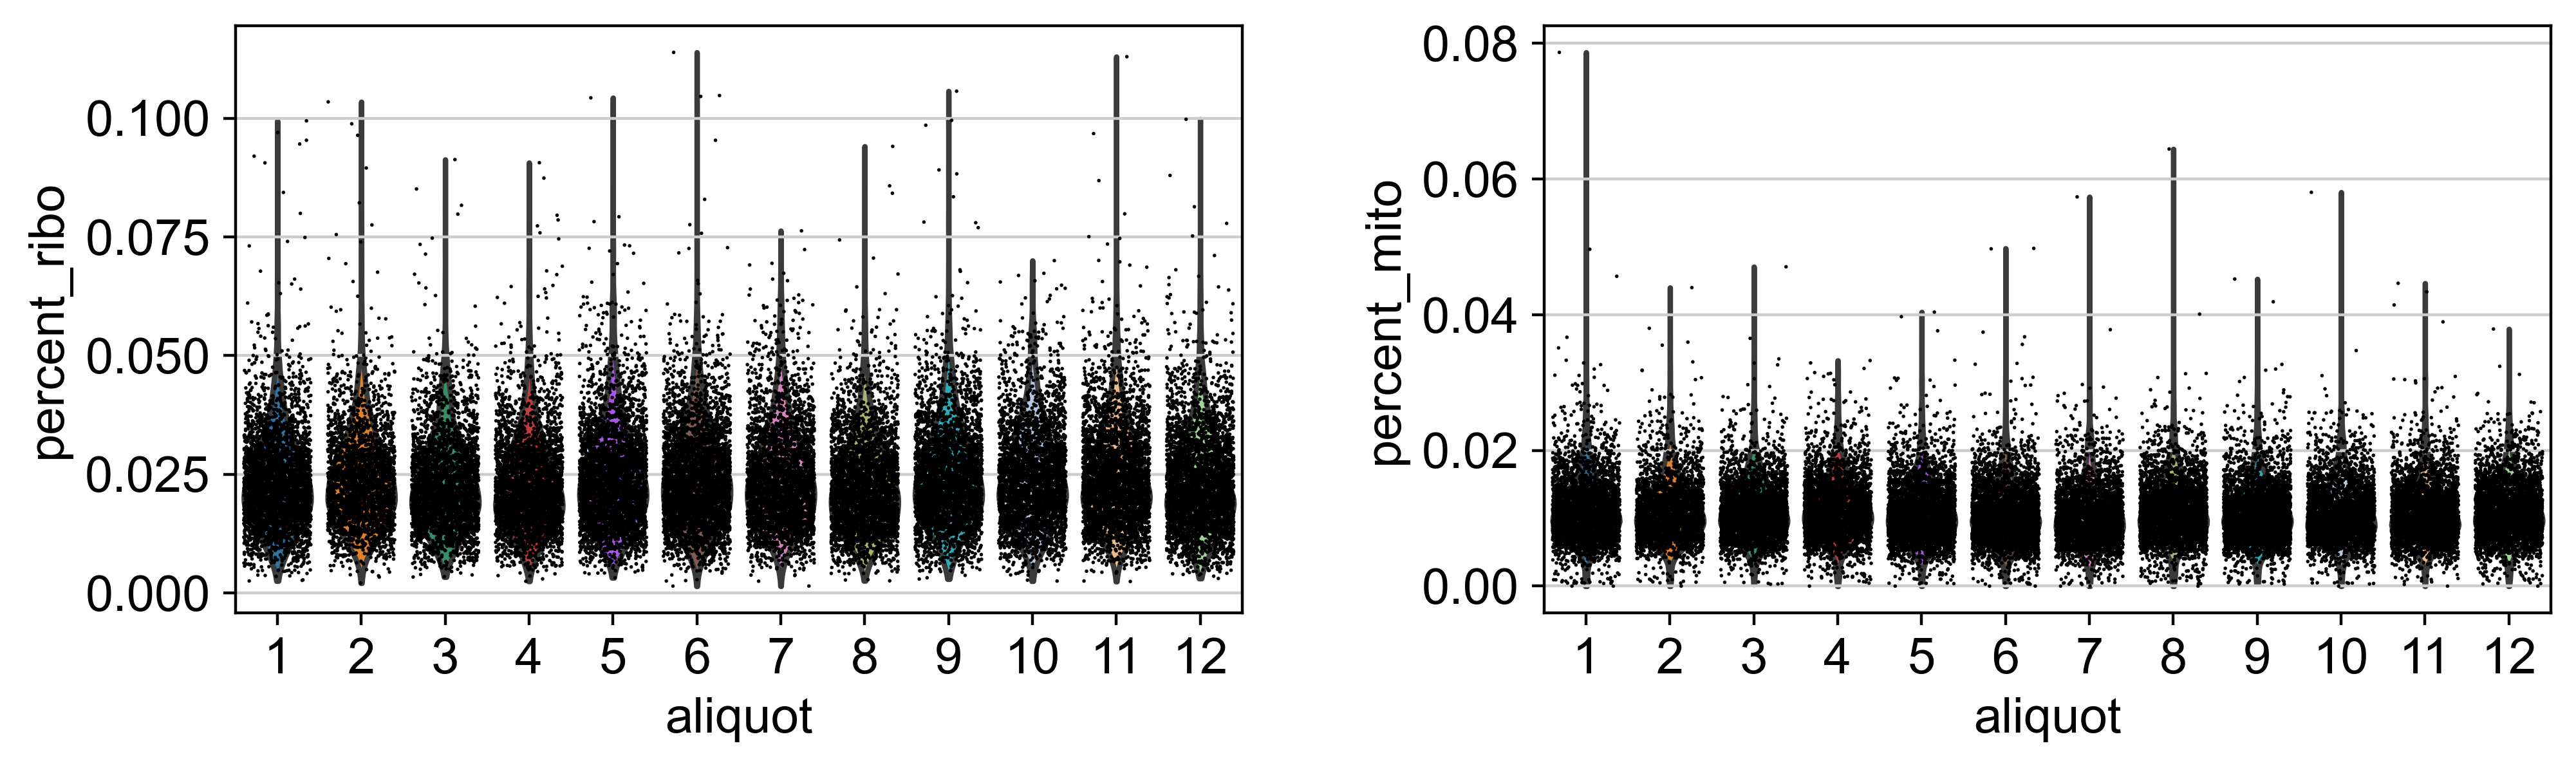

In [21]:
with plt.rc_context({'figure.figsize': (5, 3)}):
    sc.pl.violin(GEX_adata_filtered, ['percent_ribo', 'percent_mito'],
             jitter=0.4, multi_panel=True,groupby='aliquot')

In [22]:
sc.pp.normalize_total(GEX_adata_filtered, target_sum=1e4)

normalizing counts per cell
    finished (0:00:01)


In [23]:
sc.pp.log1p(GEX_adata_filtered)


In [24]:
GEX_adata_filtered.raw = GEX_adata_filtered
#Set the .raw attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [25]:
GEX_adata_filtered.write(output_d+'/T3_OAK/Anndata/OAK1to12_GEXwLineage_normalized.h5ad')

In [26]:
sc.pp.highly_variable_genes(GEX_adata_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)


extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


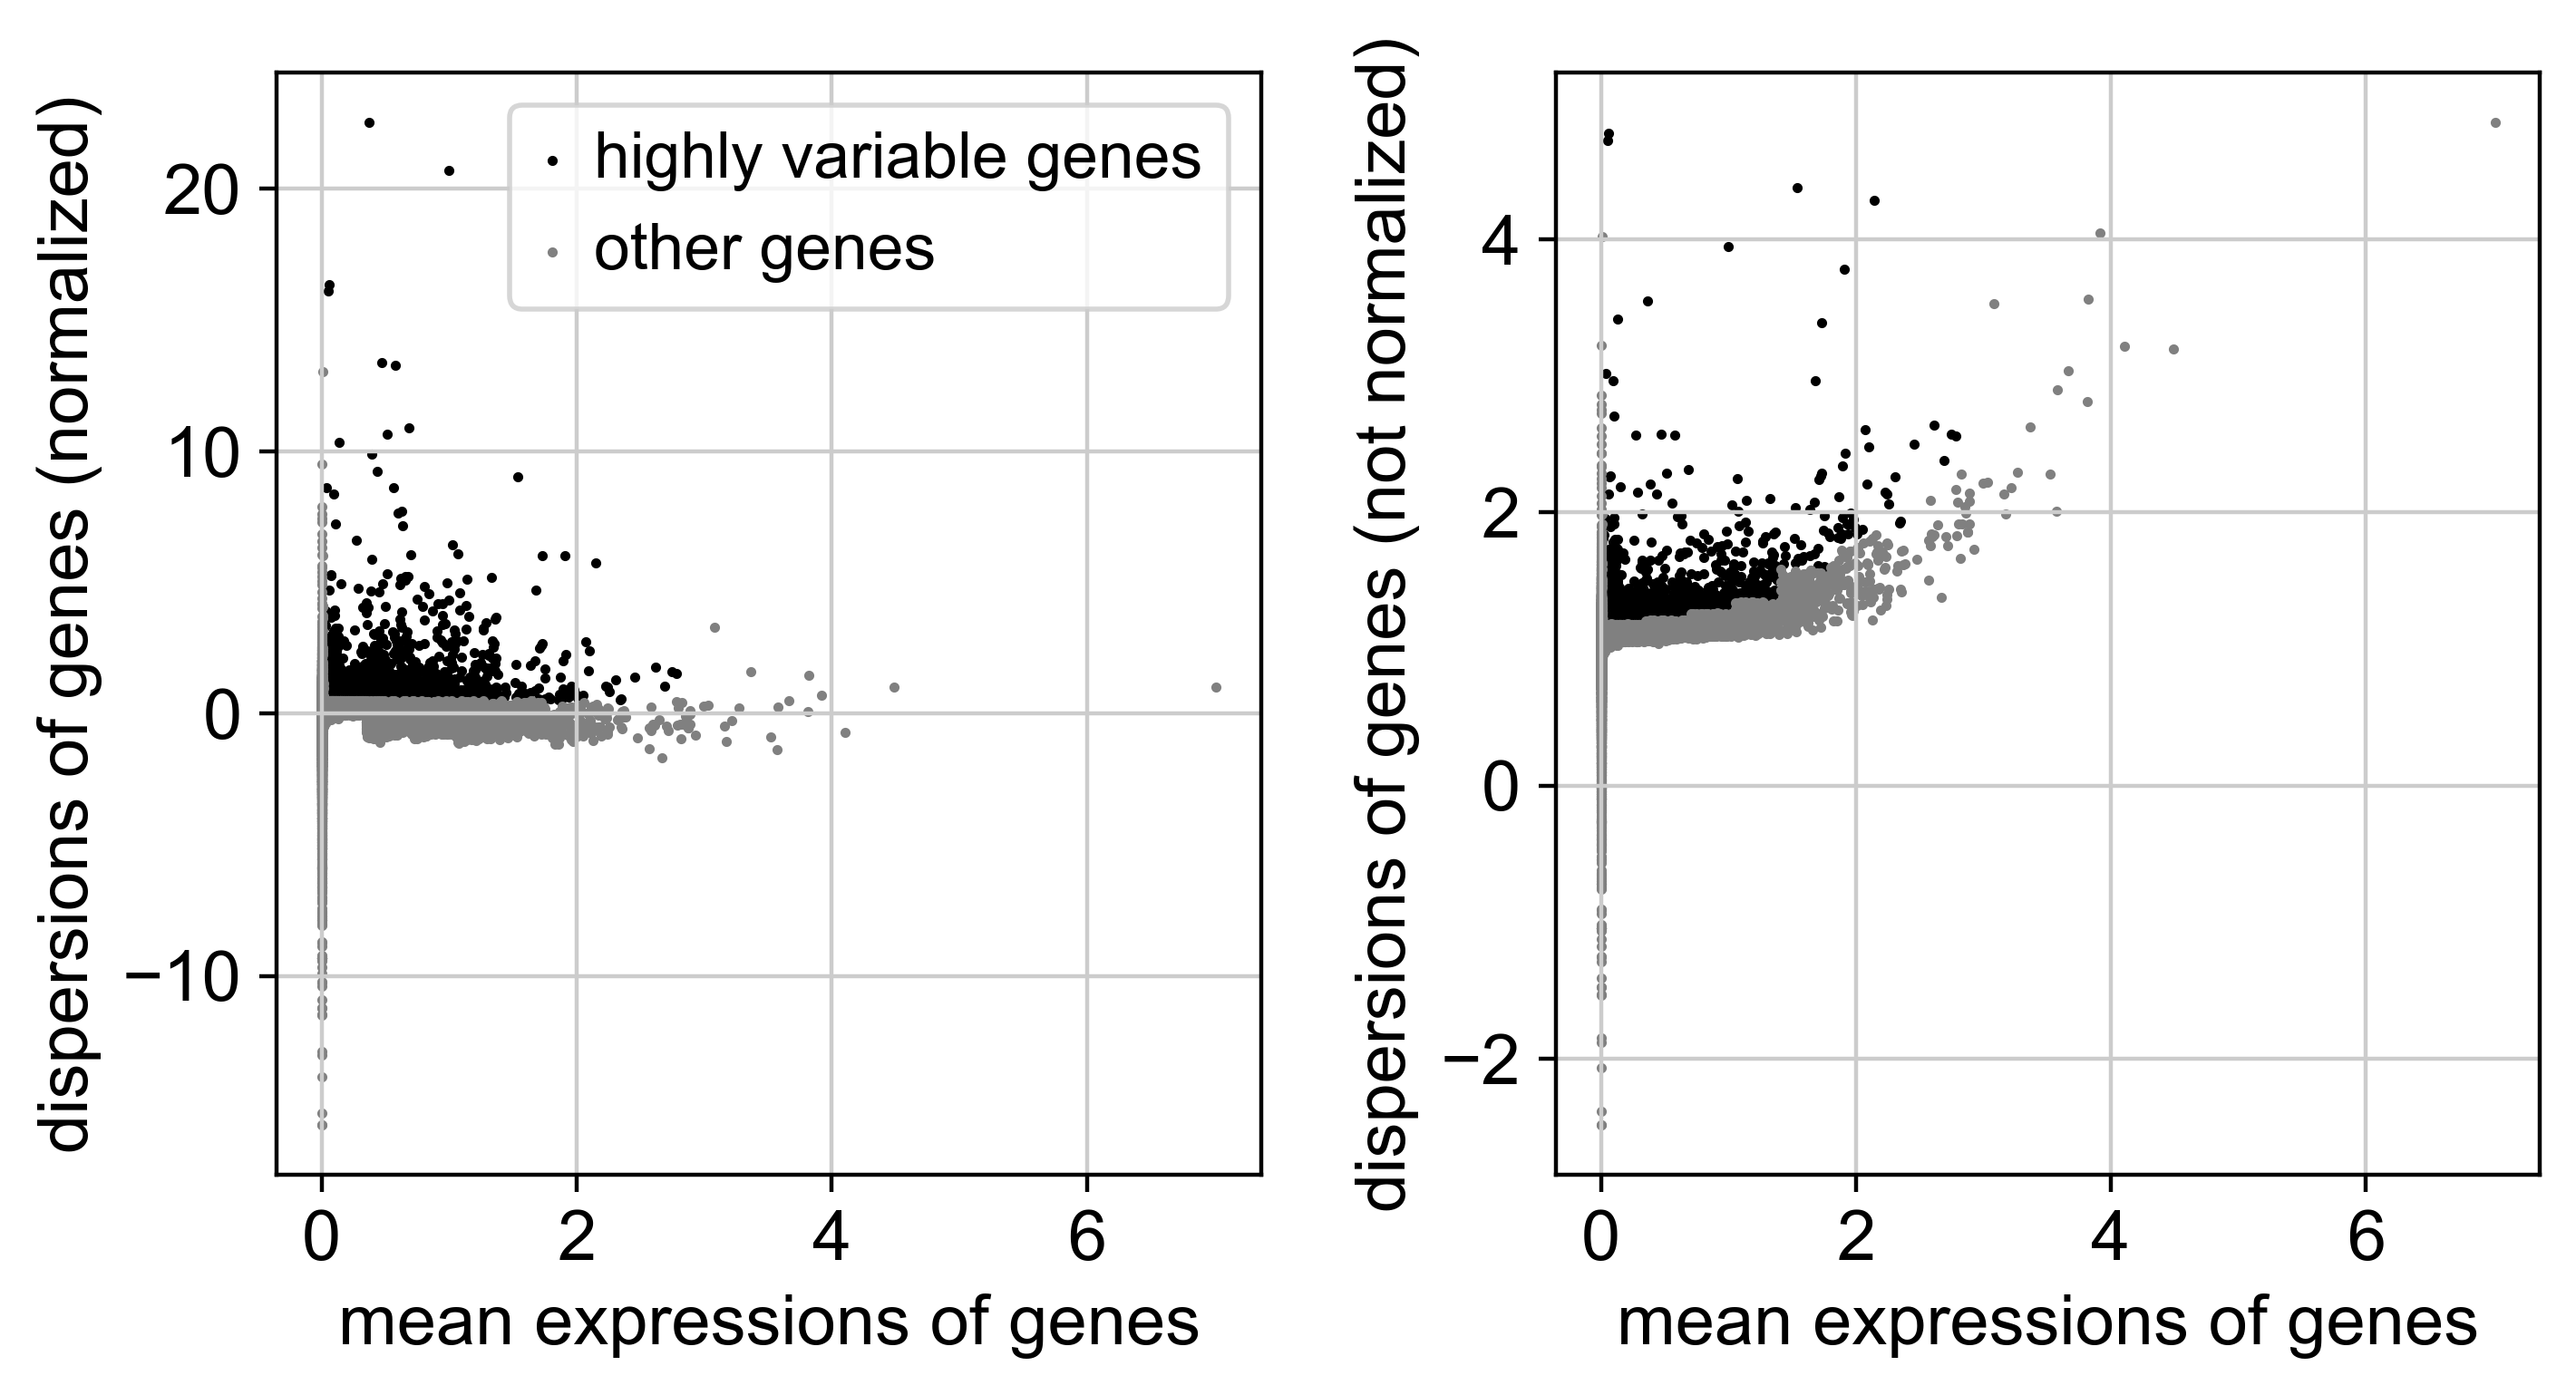

In [27]:
sc.pl.highly_variable_genes(GEX_adata_filtered)


In [28]:
sc.pp.scale(GEX_adata_filtered, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [29]:
sc.tl.pca(GEX_adata_filtered, svd_solver='arpack',n_comps=50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)


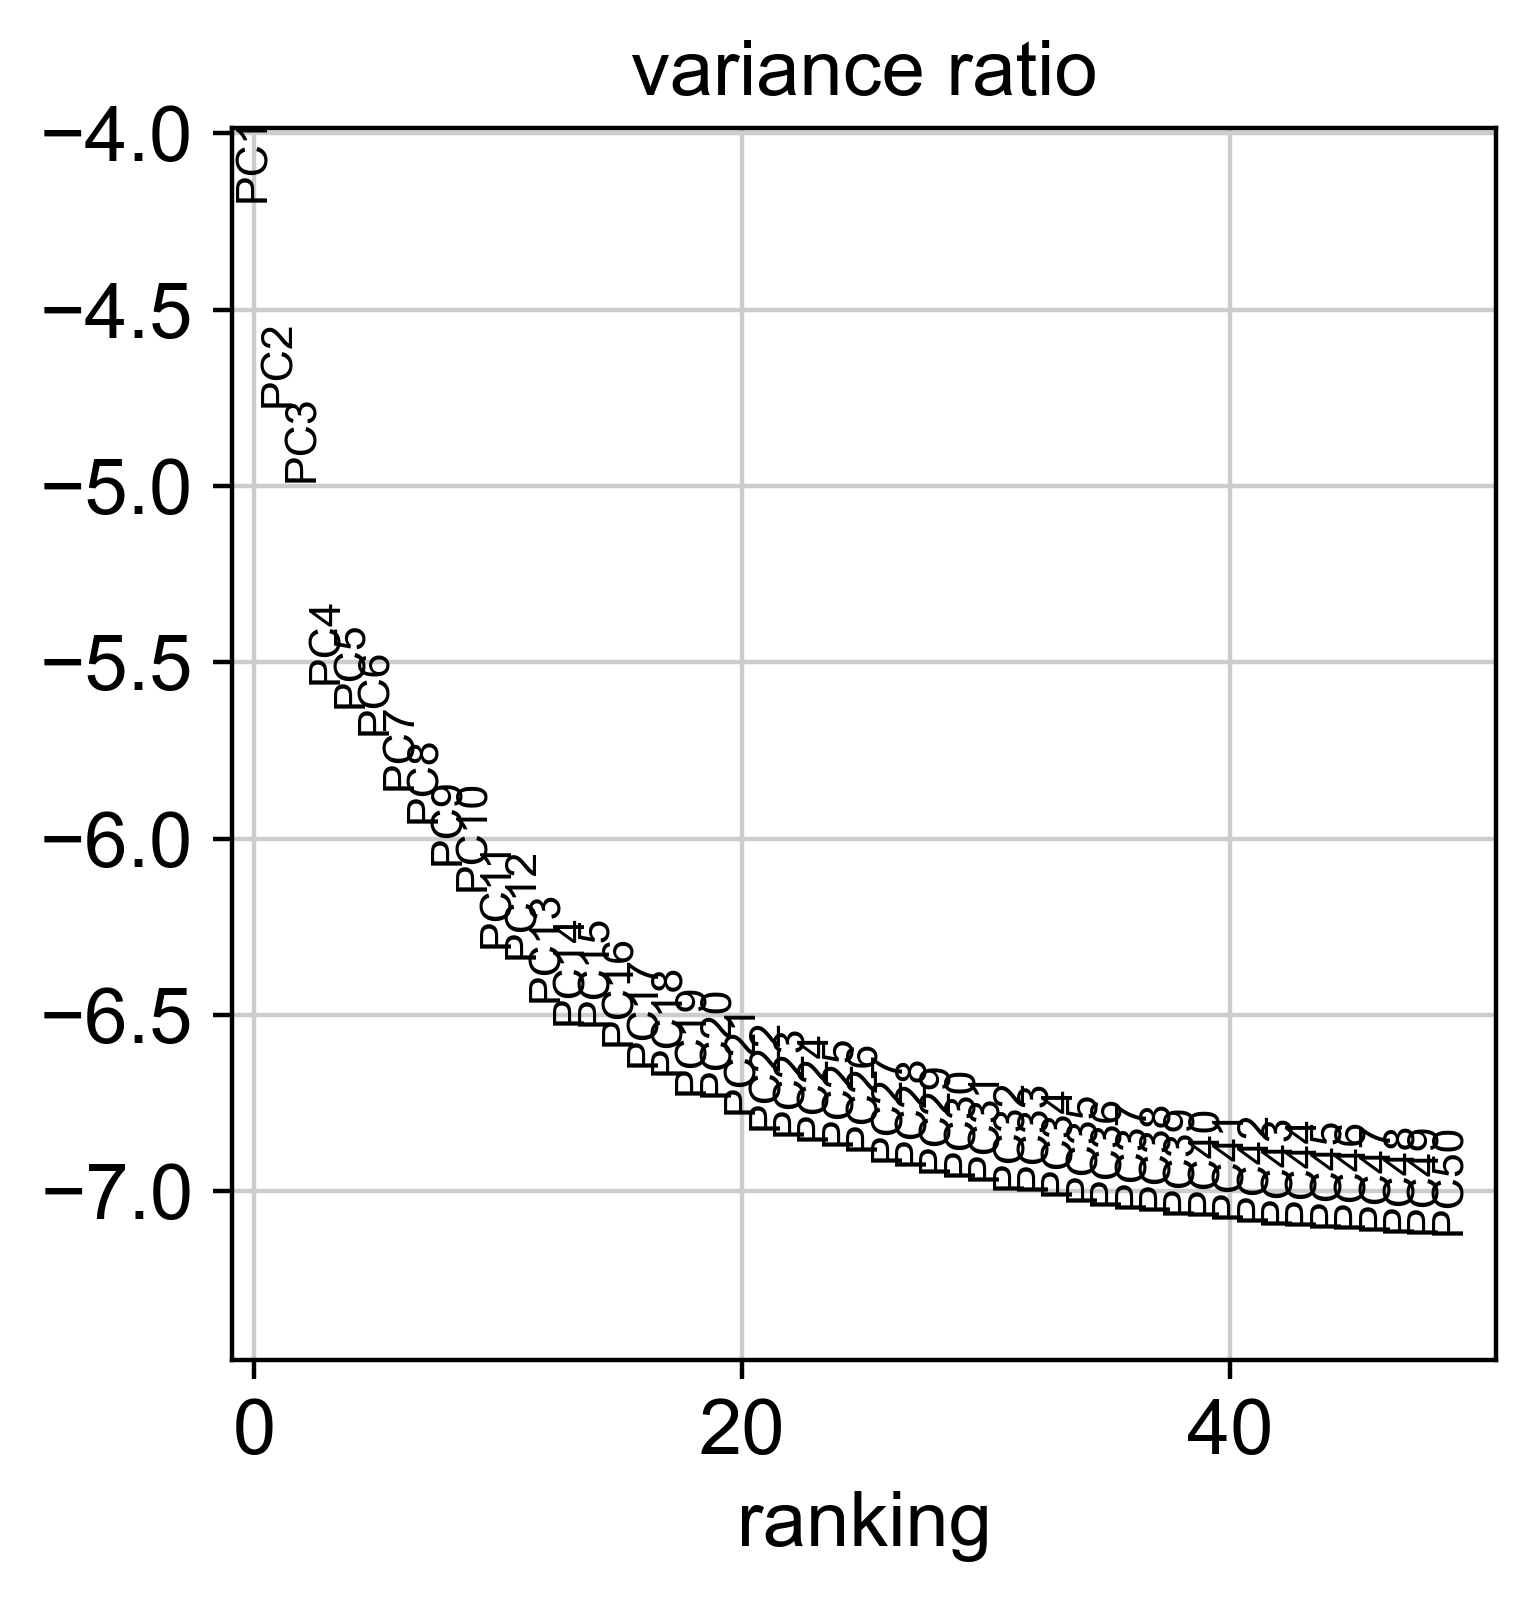

In [30]:
sc.pl.pca_variance_ratio(GEX_adata_filtered, log=True,n_pcs=50)


In [31]:
sc.pp.neighbors(GEX_adata_filtered, n_neighbors=15, n_pcs=40)


computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)


In [32]:
sc.tl.leiden(GEX_adata_filtered,resolution=1,key_added="leiden_1")


running Leiden clustering
    finished: found 13 clusters and added
    'leiden_1', the cluster labels (adata.obs, categorical) (0:00:13)


In [33]:
sc.tl.paga(GEX_adata_filtered,groups='leiden_1')
sc.pl.paga(GEX_adata_filtered, plot=False) 
sc.tl.umap(GEX_adata_filtered,init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:43)


In [44]:
GEX_adata_filtered.write(output_d+'/T3_OAK/Anndata/OAK1to12_GEXwGuide_clustered.h5ad')